<a href="https://colab.research.google.com/github/PratikNagdeve/genai-lab-assignments/blob/main/GenAI_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub tensorflow opencv-python matplotlib scikit-learn


In [ ]:
import kagglehub
dataset_path = kagglehub.dataset_download("gvclsu/water-segmentation-dataset")
print(dataset_path)


Using Colab cache for faster access to the 'water-segmentation-dataset' dataset.
/kaggle/input/water-segmentation-dataset


In [ ]:
import os

DATASET_DIR = os.path.join(dataset_path, "water_v1", "water_v1")

IMAGE_DIR = os.path.join(DATASET_DIR, "JPEGImages")
MASK_DIR  = os.path.join(DATASET_DIR, "Annotations")

print(os.listdir(IMAGE_DIR))


['stream1', 'buffalo0', 'ADE20K', 'houston', 'lab0', 'canal0', 'stream0', 'creek0', 'stream2']


In [ ]:
scenes = [
    d for d in os.listdir(IMAGE_DIR)
    if os.path.isdir(os.path.join(IMAGE_DIR, d)) and d != "ADE20K"
]

print("Scenes used:", scenes)


Scenes used: ['stream1', 'buffalo0', 'houston', 'lab0', 'canal0', 'stream0', 'creek0', 'stream2']


In [ ]:
import cv2
import numpy as np

IMG_SIZE = 256

def load_scene(scene):
    images, masks = [], []

    img_scene_dir  = os.path.join(IMAGE_DIR, scene)
    mask_scene_dir = os.path.join(MASK_DIR, scene)

    for file in os.listdir(img_scene_dir):
        if not file.endswith(".jpg"):
            continue

        img_path  = os.path.join(img_scene_dir, file)
        mask_path = os.path.join(mask_scene_dir, file.replace(".jpg", ".png"))

        if not os.path.exists(mask_path):
            continue

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE)) / 255.0
        mask = np.expand_dims(mask, axis=-1)

        images.append(img)
        masks.append(mask)

    return images, masks


In [ ]:
X, Y = [], []

for scene in scenes:
    imgs, masks = load_scene(scene)
    X.extend(imgs)
    Y.extend(masks)

X = np.array(X)
Y = np.array(Y)

print("Total samples:", X.shape, Y.shape)


Total samples: (1, 256, 256, 3) (1, 256, 256, 1)


In [ ]:
import os

scene = "buffalo0"   # test one known scene

img_scene_dir  = os.path.join(IMAGE_DIR, scene)
mask_scene_dir = os.path.join(MASK_DIR, scene)

print("Image files:", os.listdir(img_scene_dir)[:10])
print("Mask files :", os.listdir(mask_scene_dir)[:10])


Image files: ['94.png', '48.png', '61.png', '37.png', '35.png', '142.png', '104.png', '133.png', '70.png', '73.png']
Mask files : ['94.png', '48.png', '61.png', '37.png', '35.png', '142.png', '104.png', '133.png', '70.png', '73.png']


In [ ]:
import cv2
import numpy as np

IMG_SIZE = 256
VALID_EXT = (".jpg", ".png", ".jpeg")

def load_scene(scene):
    images, masks = [], []

    img_dir  = os.path.join(IMAGE_DIR, scene)
    mask_dir = os.path.join(MASK_DIR, scene)

    for file in os.listdir(img_dir):
        if not file.lower().endswith(VALID_EXT):
            continue

        img_path = os.path.join(img_dir, file)

        base = os.path.splitext(file)[0]
        mask_path = None

        for ext in [".png", ".bmp", ".jpg"]:
            candidate = os.path.join(mask_dir, base + ext)
            if os.path.exists(candidate):
                mask_path = candidate
                break

        if mask_path is None:
            continue

        img  = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE)) / 255.0
        mask = np.expand_dims(mask, axis=-1)

        images.append(img)
        masks.append(mask)

    return images, masks


In [ ]:
X, Y = [], []

for scene in scenes:
    imgs, masks = load_scene(scene)
    print(scene, "loaded:", len(imgs))
    X.extend(imgs)
    Y.extend(masks)

X = np.array(X)
Y = np.array(Y)

print("FINAL DATASET:", X.shape, Y.shape)


stream1 loaded: 24
buffalo0 loaded: 144
houston loaded: 1
lab0 loaded: 33
canal0 loaded: 10
stream0 loaded: 15
creek0 loaded: 50
stream2 loaded: 3
FINAL DATASET: (280, 256, 256, 3) (280, 256, 256, 1)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, Y_train.shape)
print("Val  :", X_val.shape, Y_val.shape)


Train: (224, 256, 256, 3) (224, 256, 256, 1)
Val  : (56, 256, 256, 3) (56, 256, 256, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def down_block(x, filters, batchnorm=True):
    x = layers.Conv2D(filters, 4, strides=2, padding="same")(x)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    return x

def up_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, 4, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Concatenate()([x, skip])
    return x


In [ ]:
def build_generator():
    inputs = layers.Input(shape=(256,256,3))

    d1 = down_block(inputs, 64, batchnorm=False)
    d2 = down_block(d1, 128)
    d3 = down_block(d2, 256)
    d4 = down_block(d3, 512)

    bottleneck = layers.Conv2D(512, 4, strides=2, padding="same")(d4)
    bottleneck = layers.ReLU()(bottleneck)

    u1 = up_block(bottleneck, d4, 512)
    u2 = up_block(u1, d3, 256)
    u3 = up_block(u2, d2, 128)
    u4 = up_block(u3, d1, 64)

    outputs = layers.Conv2DTranspose(1, 4, strides=2, padding="same",
                                     activation="sigmoid")(u4)

    return models.Model(inputs, outputs)


In [ ]:
def build_discriminator():
    img = layers.Input(shape=(256,256,3))
    mask = layers.Input(shape=(256,256,1))

    x = layers.Concatenate()([img, mask])

    x = down_block(x, 64, batchnorm=False)
    x = down_block(x, 128)
    x = down_block(x, 256)

    x = layers.Conv2D(1, 4, padding="same")(x)

    return models.Model([img, mask], x)


In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, fake):
    real_loss = loss_obj(tf.ones_like(real), real)
    fake_loss = loss_obj(tf.zeros_like(fake), fake)
    return real_loss + fake_loss

def generator_loss(fake):
    return loss_obj(tf.ones_like(fake), fake)

def l1_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))


In [ ]:
generator = build_generator()
discriminator = build_discriminator()

gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [ ]:
X_train = X_train.astype("float32")
Y_train = Y_train.astype("float32")

X_val   = X_val.astype("float32")
Y_val   = Y_val.astype("float32")


In [ ]:
def train_step(image, mask):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_mask = generator(image, training=True)

        real_output = discriminator([image, mask], training=True)
        fake_output = discriminator([image, generated_mask], training=True)

        gen_loss = generator_loss(fake_output) + 100 * l1_loss(mask, generated_mask)
        disc_loss = discriminator_loss(real_output, fake_output)

    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [ ]:
BATCH_SIZE = 8

train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train, Y_train)
).shuffle(500).batch(BATCH_SIZE)


In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    for step, (img, mask) in enumerate(train_dataset):
        g_loss, d_loss = train_step(img, mask)

        if step % 50 == 0:
            print(f"Step {step} | G Loss: {g_loss.numpy():.4f} | D Loss: {d_loss.numpy():.4f}")



Epoch 1/5
Step 0 | G Loss: 23.9510 | D Loss: 1.1180

Epoch 2/5
Step 0 | G Loss: 18.2769 | D Loss: 1.1177

Epoch 3/5
Step 0 | G Loss: 9.4128 | D Loss: 1.1597

Epoch 4/5
Step 0 | G Loss: 8.2119 | D Loss: 1.3217

Epoch 5/5
Step 0 | G Loss: 6.4865 | D Loss: 1.1221


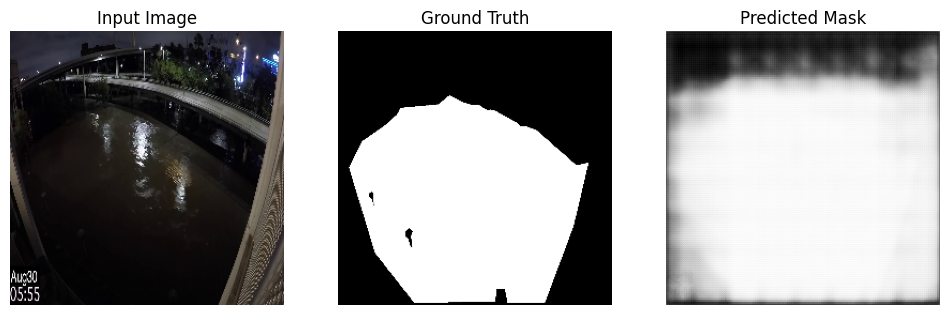

In [ ]:
import matplotlib.pyplot as plt

def show_predictions(index=0):
    img = X_val[index:index+1]
    gt  = Y_val[index]

    pred = generator(img, training=False)[0]

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Input Image")
    plt.imshow(img[0])
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Ground Truth")
    plt.imshow(gt.squeeze(), cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(pred.numpy().squeeze(), cmap="gray")
    plt.axis("off")

    plt.show()

show_predictions(0)


In [ ]:
def iou_score(y_true, y_pred, thresh=0.5):
    y_pred = (y_pred > thresh).astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / (union + 1e-7)

ious = []
for i in range(len(X_val)):
    pred = generator(X_val[i:i+1], training=False).numpy()
    ious.append(iou_score(Y_val[i], pred))

print("Mean IoU:", np.mean(ious))


Mean IoU: 0.47504276
